# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [303]:
%%pycodestyle

class MyKmeans:
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.init = init
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter

    def init_centroids(self, X):
        if self.init == 'random':
            self.centroids = X[np.random.choice(X.shape[0], self.k)]
        elif self.init == 'k-means':
            self.centroids = np.empty((self.k, X.shape[1]))
            self.centroids[0] = X[np.random.choice(X.shape[0], 1)]

            for itera in range(1, self.k):
                distances = ((X[np.newaxis, :] - self.centroids[:itera, np.newaxis]) ** 2).sum(axis=2)
                mins = np.min(distances, axis=0)
                minsum = np.sum(mins, axis=0)
                probs = mins / minsum
                self.centroids[itera] = X[np.random.choice(X.shape[0], size=1, replace=False, p=probs)]

    def init_random(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.k)]

    def init_plpl(self, X):
        self.centroids = np.empty((self.k, X.shape[1]))
        self.centroids[0] = X[np.random.choice(X.shape[0], 1)]

        for itera in range(1, self.k):
            distances = ((X[np.newaxis, :] - self.centroids[:itera, np.newaxis]) ** 2).sum(axis=2)
            mins = np.min(distances, axis=0)
            minsum = np.sum(mins, axis=0)
            probs = mins / minsum
            self.centroids[itera] = X[np.random.choice(X.shape[0], size=1, replace=False, p=probs)]

    def numpy_dist(self, X, Y):
        x_dist = (X ** 2).sum(axis=1)
        y_dist = (Y ** 2).sum(axis=1)
        xy_dist = X.dot(Y.T)
        dist = - 2 * xy_dist + y_dist + x_dist.reshape(-1, 1)
        return dist

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        np.random.seed(self.random_state)
        self.labels = np.empty(X.shape[0])

        self.centroids = np.empty((self.k, X.shape[1] + 1))

        self.init_centroids(X)

        for _ in range(self.max_iter):
            distances = self.numpy_dist(X, self.centroids)
            self.labels = distances.argmin(axis=1)
            new_centroids = np.array([X[self.labels == k].mean(axis=0) for k in range(self.centroids.shape[0])])
            if ((new_centroids - self.centroids) ** 2).sum() < 0.0001:
                return self
            self.centroids = new_centroids
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        labels = np.empty(X.shape[0])
        distances = self.numpy_dist(X, self.centroids)
        labels = distances.argmin(axis=1)
        return labels


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=100, mbatchsize=10, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.init = init
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.mbatchsize = mbatchsize

    def fit(self, X, y=None):
        np.random.seed(self.random_state)

        self.labels = np.zeros((X.shape[0]))

        self.centroids = np.empty((self.k, X.shape[1]))

        if self.init == 'random':
            self.init_random(X)
        elif self.init == 'k-means':
            self.init_plpl(X)
        self.v = np.zeros(self.k)
        for _ in range(self.max_iter):
            self.randbatch = np.random.choice(X.shape[0], self.mbatchsize)
            batchpts = X[self.randbatch]
            batchdistances = self.numpy_dist(batchpts, self.centroids)
            batchlabels = batchdistances.argmin(axis=1)
            l_centroids = self.centroids
            for i, x in enumerate(batchpts):
                self.v[batchlabels[i]] += 1
                buff = 1.0 / self.v[batchlabels[i]]
                self.centroids[batchlabels[i]] = (1 - buff) * self.centroids[batchlabels[i]] + buff * batchpts[i]
                self.labels[self.randbatch[i]] = batchlabels[i]
        return self

3:80: E501 line too long (97 > 79 characters)
25:80: E501 line too long (102 > 79 characters)
29:80: E501 line too long (103 > 79 characters)
39:80: E501 line too long (98 > 79 characters)
43:80: E501 line too long (99 > 79 characters)
67:80: E501 line too long (112 > 79 characters)
86:80: E501 line too long (111 > 79 characters)
122:80: E501 line too long (113 > 79 characters)


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

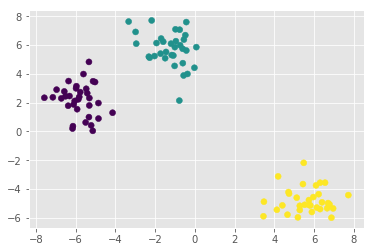

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

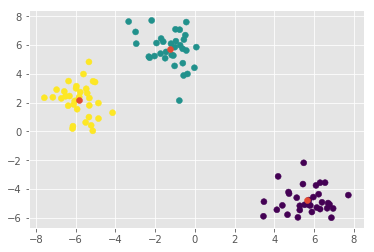

In [205]:
## Работоспособность MyKmeans
kmeans = MyKmeans(k=3)

kmeans.fit(X)

plt.scatter(X[:,0], X[:, 1], c=kmeans.predict(X))
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1])

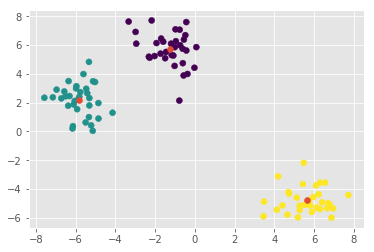

In [164]:
## Работоспособность MyKmeans++
kmeans = MyKmeans(k=3, init='k-means')

kmeans.fit(X)

plt.scatter(X[:,0], X[:, 1], c=kmeans.predict(X))
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1])

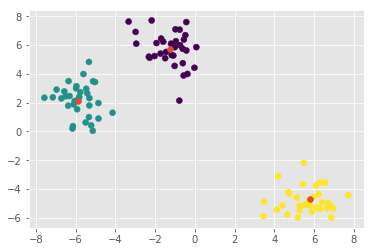

In [227]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
kmeans = MiniBatchKMeans(k=3)

kmeans.fit(X)

plt.scatter(X[:,0], X[:, 1], c=kmeans.predict(X))
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1])

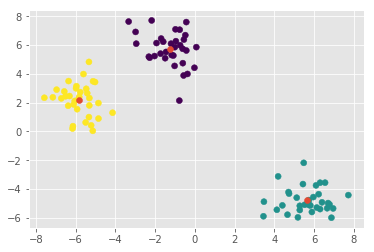

In [177]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
kmeans = MiniBatchKMeans(k=3, init='k-means')

kmeans.fit(X)

plt.scatter(X[:,0], X[:, 1], c=kmeans.predict(X))
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1])

In [38]:
## Время выполнения алгоритма Kmeans из sklearn
from sklearn.cluster import KMeans
%time KMeans(n_clusters=3).fit(X)

CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 20.9 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [238]:
from sklearn.cluster import MiniBatchKMeans
%time MiniBatchKMeans(n_clusters=3).fit(X)

CPU times: user 15.2 ms, sys: 631 µs, total: 15.8 ms
Wall time: 15 ms


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=3,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [22]:
## Время выполнения алгоритма MyKmeans
%time MyKmeans(k=3).fit(X)

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 1.33 ms


In [76]:
## Время выполнения алгоритма MyKmeans++
%time MyKmeans(k=3,init='k-means').fit(X)

CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 1.3 ms


In [235]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
%time MiniBatchKMeans(k=3).fit(X)

CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 14.3 ms


In [236]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
%time MiniBatchKMeans(k=3, init='k-means').fit(X)

CPU times: user 13.9 ms, sys: 3.87 ms, total: 17.8 ms
Wall time: 16.9 ms


Text(0,0.5,'time')

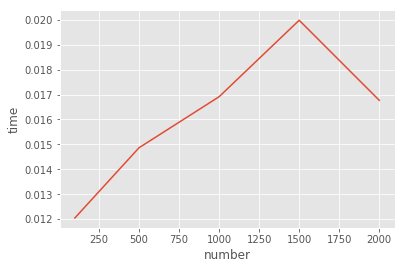

In [241]:
## Время выполнения алгоритма Kmeans из sklearn
import time
size = [100, 500, 1000, 1500, 2000]
t = np.empty(len(size))
for i, s in enumerate(size):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    alg = KMeans(n_clusters=3)
    t1 = time.time()
    alg.fit(X)
    t[i] = time.time() - t1
plt.plot(size, t)
plt.xlabel('number')
plt.ylabel('time')

Text(0,0.5,'time')

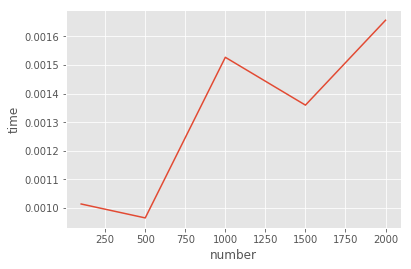

In [245]:
#MyKmeans
size = [100, 500, 1000, 1500, 2000]
t = np.empty(len(size))
for i, s in enumerate(size):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    alg = MyKmeans(k=3)
    t1 = time.time()
    alg.fit(X)
    t[i] = time.time() - t1
plt.plot(size, t)
plt.xlabel('number')
plt.ylabel('time')

Text(0,0.5,'time')

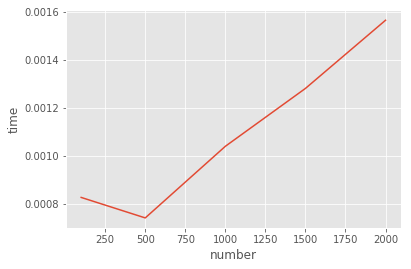

In [268]:
#KMeans++
size = [100, 500, 1000, 1500, 2000]
t = np.empty(len(size))
for i, s in enumerate(size):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    alg = MyKmeans(k=3, init='k-means')
    t1 = time.time()
    alg.fit(X)
    t[i] = time.time() - t1
plt.plot(size, t)
plt.xlabel('number')
plt.ylabel('time')

Text(0,0.5,'time')

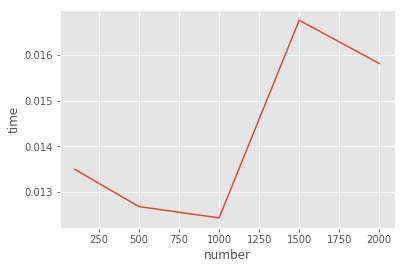

In [265]:
#MiniBatch
size = [100, 500, 1000, 1500, 2000]
t = np.empty(len(size))
for i, s in enumerate(size):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    alg = MiniBatchKMeans(k=3)
    t1 = time.time()
    alg.fit(X)
    t[i] = time.time() - t1
plt.plot(size, t)
plt.xlabel('number')
plt.ylabel('time')

Text(0,0.5,'time')

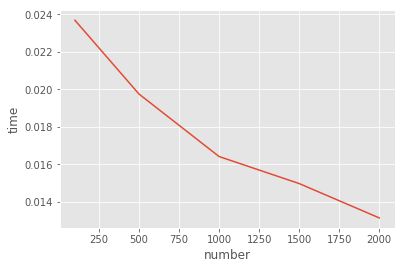

In [277]:
#MiniBatch++
size = [100, 500, 1000, 1500, 2000]
t = np.empty(len(size))
for i, s in enumerate(size):
    X, y = make_blobs(n_samples=s, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    alg = MiniBatchKMeans(k=3, init='k-means')
    t1 = time.time()
    alg.fit(X)
    t[i] = time.time() - t1
plt.plot(size, t)
plt.xlabel('number')
plt.ylabel('time')

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [278]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [279]:
#Удалите все признаки кроме 36 ключевых слов.
df_sns=df_sns.drop(df_sns.columns[[0, 1, 2]], axis=1)
df_sns.head()

,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,69,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [280]:
#Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
df_sns=(df_sns-df_sns.mean())/df_sns.std()
df_sns.head()

,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.634517,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.826136,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,1.062677,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.826136,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.552395,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


In [281]:
#Используйте метод k-means чтобы выделить 9 кластеров
df_sns_np=df_sns.values

In [306]:
## MyKMeans
result=MyKmeans(k=9).fit(df_sns_np)
print(df_sns.columns[(result.centroids.copy()).argsort()[:,::-1][:,:3]])

Index([['kissed', 'drugs', 'hair'], ['football', 'baseball', 'basketball'],
       ['marching', 'band', 'music'], ['shopping', 'cute', 'church'],
       ['dress', 'shopping', 'dance'], ['tennis', 'sports', 'church'],
       ['blonde', 'soccer', 'bible'], ['hollister', 'abercrombie', 'shopping'],
       ['softball', 'volleyball', 'basketball']],
      dtype='object')


In [296]:
## MyKMeans++
result=MyKmeans(k=9, init='k-means').fit(df_sns_np)
print(df_sns.columns[(result.centroids.copy()).argsort()[:,::-1][:,:3]])

Index([['blonde', 'jesus', 'death'], ['bible', 'jesus', 'god'],
       ['cheerleading', 'shopping', 'football'],
       ['shopping', 'hollister', 'mall'],
       ['football', 'basketball', 'baseball'],
       ['volleyball', 'softball', 'basketball'], ['marching', 'band', 'music'],
       ['kissed', 'drugs', 'hair'], ['tennis', 'sports', 'church']],
      dtype='object')


In [304]:
## MyKMeans с MiniBatchMyKMeans
result=MiniBatchKMeans(k=9, max_iter=1000, mbatchsize=100).fit(df_sns_np)
print(df_sns.columns[(result.centroids.copy()).argsort()[:,::-1][:,:3]])

Index([['softball', 'sports', 'volleyball'], ['kissed', 'sex', 'hair'],
       ['drunk', 'hair', 'drugs'], ['basketball', 'baseball', 'football'],
       ['shopping', 'dance', 'swimming'], ['marching', 'band', 'music'],
       ['bible', 'god', 'church'],
       ['abercrombie', 'hollister', 'cheerleading'],
       ['blonde', 'baseball', 'tennis']],
      dtype='object')


In [305]:
## MyKMeans++ с MiniBatchMyKMeans
result=MiniBatchKMeans(k=9, init='k-means', max_iter=1000, mbatchsize=100).fit(df_sns_np)
print(df_sns.columns[(result.centroids.copy()).argsort()[:,::-1][:,:3]])

Index([['blonde', 'tennis', 'baseball'], ['sex', 'blonde', 'hair'],
       ['hollister', 'abercrombie', 'shopping'], ['kissed', 'drugs', 'hair'],
       ['softball', 'basketball', 'sports'], ['bible', 'jesus', 'god'],
       ['dress', 'shopping', 'dance'],
       ['volleyball', 'basketball', 'swimming'], ['shopping', 'cute', 'mall']],
      dtype='object')


## Вывод
Выявить лучший алгоритм достаточно сложно, тк для всех верно:

1) Алгоритмы используют случайный выбор начальных центроид (центров масс)

2) Алгоритмы гарантируют нахождение одного из локальных минимумов, зависящит от нач условий.

3) из 1) 2) => неустойчивость

Не совсем для всех кластеров можно дать однозначную тематическую интерпретацию:

Например: 'abercrombie', 'hollister', 'cheerleading' -> Стиль одежды, однако черлидинг мешает, хотя можно интерпретировать как область интересов черлидершь))

Но есть и однозанчно интепретируемые 'bible', 'jesus', 'god' -> однозначно религия 

про спорт очевидно.

Видимо, некоторые признаки находятся на границе и в зависимости от нач услови перетекают из одного кластера в другой